# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [91]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2022-09-20_OnlyCuasi'       # timestamp of the model
# SPLIT_NAME = 'testLaRiojaICVVCopasAll'                   # dataset split to predict
SPLIT_NAME = 'voluntarios_estudios'
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)

## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [92]:
from imgclas import test_utils
import sklearn.metrics as metrics
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

y, yhat = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 10.106540756225586
MSE: 179.5518984485537
RMSE: 13.399697699894341
R-Squared: 0.921933957196281


## Violin plots

In [93]:
import plotly.graph_objects as go

import pandas as pd

df = pd.DataFrame(data={'true_volume': pred_dict['true_value'], 'pred_volume': pred_dict['pred_value']})
# df = df.astype({"true_volume": type(pred_dict['pred_value'][0])})

fig = go.Figure()

volumes = [50, 75, 100, 125, 150, 175, 200]
for vol in volumes:
    fig.add_trace(go.Violin(x=df['true_volume'][df['true_volume'] == vol],
                            y=df['pred_volume'][df['true_volume'] == vol],
                            name=vol,
                            box_visible=True,
                            meanline_visible=True))
fig.update_traces(meanline_visible=True,
                  points='all', # show all points
                  jitter=0.05,  # add some jitter on points for better visibility
                  scalemode='count') #scale violin plot area with total count
fig.update_layout(
    title_text="Predicted volumes distribution")
    
fig.write_image("/srv/image-results/violin_plot.png")

In [46]:
df[df.isin([275]).any(1)]

,true_volume,pred_volume
88,275,175.703217


In [47]:
df.shape

(229, 2)

In [48]:
extra=df.loc[88]
df.drop(index=88, inplace=True)

In [49]:
df.true_volume.value_counts()

100    109
125     45
150     29
75      19
50      10
175      9
200      7
Name: true_volume, dtype: int64

In [55]:
x=extra.true_volume
y=extra.pred_volume

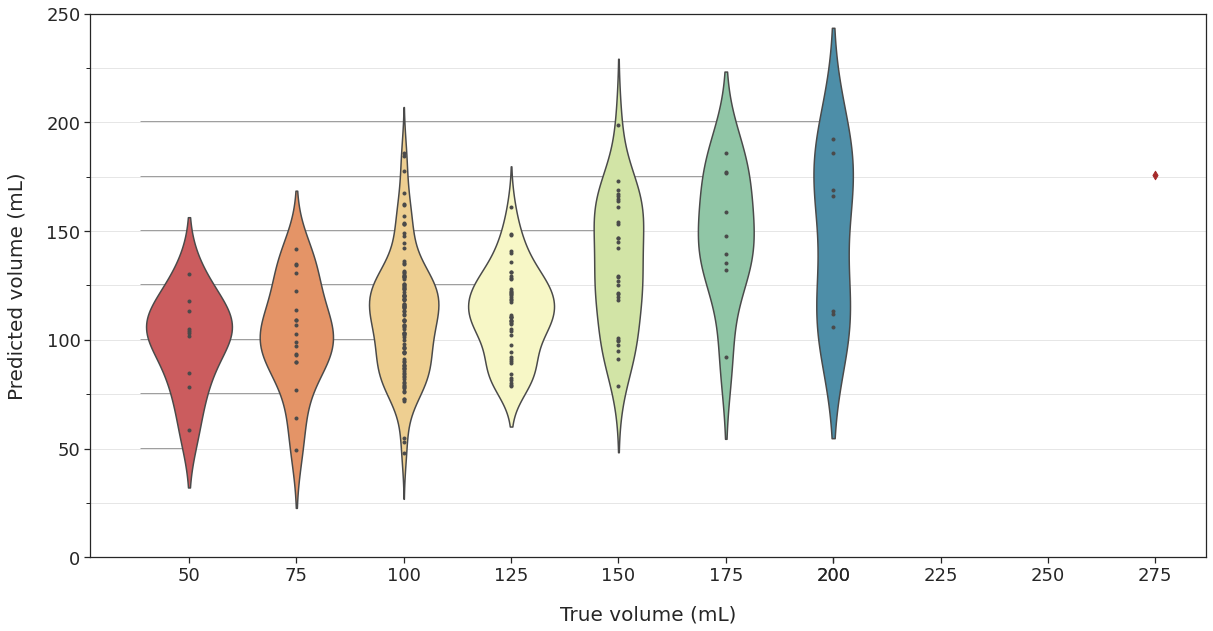

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

sns.set_theme()
sns.set_style(style='white') 

fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (20,10)

    
sns.violinplot(x='true_volume',
                    y='pred_volume',
                    data=df, inner="points",
                    palette="Spectral",
               scatter_kws={"zorder":10},
               ax=ax,
              )

for i, v in enumerate(volumes):
    xrange = np.linspace(-0.45, i, 10)
    ax.plot(xrange, [v]*len(xrange), zorder=-1, color='0.5')
#     sns.lineplot(xrange, [v]*len(xrange), color='0.5', ax=ax)
ax.scatter(i+3,y,marker='d',c="brown")
# ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.set_xlabel(xlabel='True volume (mL)', labelpad=20, fontsize=20)
ax.set_ylabel(ylabel='Predicted volume (mL)', labelpad=20, fontsize=20)
extraticks=[6, 7, 8, 9]
ax.set_xticks(list(ax.get_xticks()) + extraticks)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[7]='200'
labels[8]='225'
labels[9]='250'
labels[10]='275'
ax.set_xticklabels(labels)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
plt.ylim([0, 250])
plt.setp(ax.collections, alpha=1)
# plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",              marker='X', s=100, edgecolor='navy')
plt.savefig('/srv/image-results/violin_plot_voluntarios_estudios.png',bbox_inches='tight')
plt.show()